In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('stocks.csv', parse_dates = ['Date'], index_col = 'Date')
df = df.asfreq('B') 
df['Close'].interpolate(inplace =  True)
df.head()

,Open,High,Low,Close,Change,Volume
Date,,,,,,
2008-02-22,"10,634.22","10,635.42","10,546.38","10,607.29",0,"313,082,688"
2008-02-25,"10,625.66","10,709.06","10,579.49","10,588.84",-18.45,"273,149,184"
2008-02-26,"10,596.40","10,668.35","10,578.01","10,668.35",79.51,"265,668,784"
2008-02-27,"10,670.68","10,732.92","10,623.36","10,664.36",-3.99,"396,419,776"
2008-02-28,"10,688.98","10,724.21","10,655.23","10,704.15",39.79,"325,539,584"


In [7]:
for col in df.columns:
    df[col] = df[col].astype(str).replace(',', '', regex=True)
    df[col] = df[col].astype('float64')

(3393, 6)
               Open          High           Low         Close       Change  \
count   3221.000000   3221.000000   3221.000000   3221.000000  3221.000000   
mean   18806.389208  18913.961723  18694.557457  18801.652980     6.662738   
std     9556.736989   9599.905455   9502.488358   9550.963841   288.333717   
min     3634.560000   3742.310000   3623.350000   3647.100000 -8060.960000   
25%     8418.150000   8479.860000   8348.880000   8426.350000   -68.460000   
50%    21777.350000  21885.330000  21640.080000  21771.630000     6.330000   
75%    27911.000000  28108.020000  27656.070000  27895.150000    95.560000   
max    36317.920000  36389.500000  36132.760000  36234.200000  7957.090000   

             Volume  
count  3.221000e+03  
mean   2.006365e+08  
std    1.348805e+08  
min   -1.525267e+08  
25%    1.120844e+08  
50%    1.702730e+08  
75%    2.543143e+08  
max    1.124724e+09  


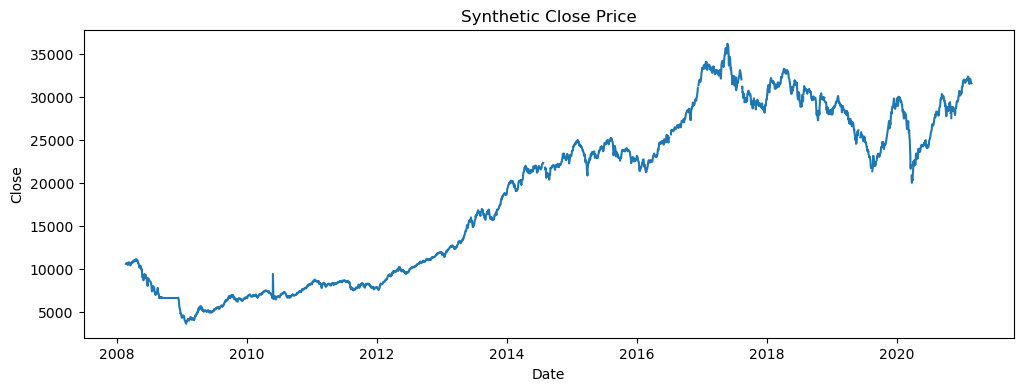

In [9]:
print(df.shape)
print(df.describe())

plt.figure(figsize = (12, 4))
plt.plot(df['Close'])
plt.title('Synthetic Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

In [11]:
df['Close'].isnull().sum()

172

In [13]:
train_per = 0.8
split = int(len(df) * train_per)
train = df.iloc[:split]
test = df.iloc[split:]

In [15]:
train['Close'] = train['Close'].interpolate()
test['Close'] = test['Close'].interpolate()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluation_series(true, pred, label='Model'):
    """
    Evaluate a time series forecast.

    Parameters:
    - true: actual values (pd.Series or np.array)
    - pred: predicted values (pd.Series or np.array)
    - label: optional string for model name

    Prints RMSE and MAE.
    """
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f'{label} → RMSE: {rmse:.4f}, MAE: {mae:.4f}')


AR(p = 5) → RMSE: 6093.0536, MAE: 5237.8613


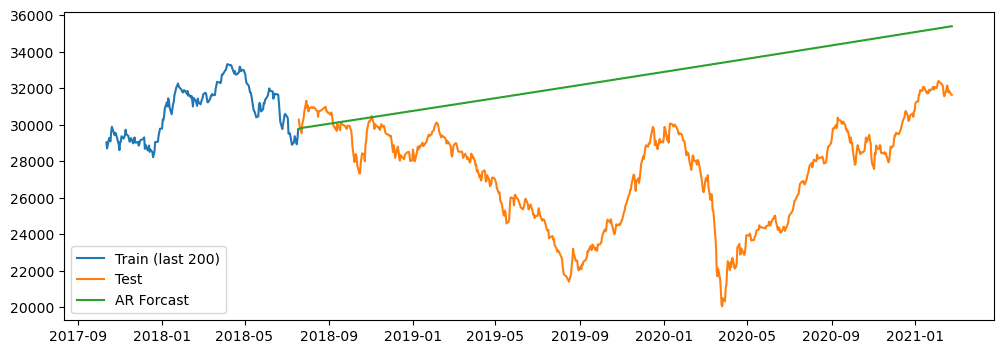

In [19]:
p = 5 # lag order
ar_model = AutoReg(train['Close'], lags = p, old_names=False).fit()
ar_forcast = ar_model.predict(start = test.index[0], end = test.index[-1], dynamic = False)

evaluation_series(test['Close'], ar_forcast, 'AR(p = 5)')

plt.figure(figsize = (12, 4))
plt.plot(train['Close'].iloc[-200:], label = 'Train (last 200)')
plt.plot(test['Close'], label = 'Test')
plt.plot(ar_forcast, label = 'AR Forcast')
plt.legend()
plt.show()

MA(q = 3), ARIMA(0,0, 3) → RMSE: 11136.5166, MAE: 10778.0229


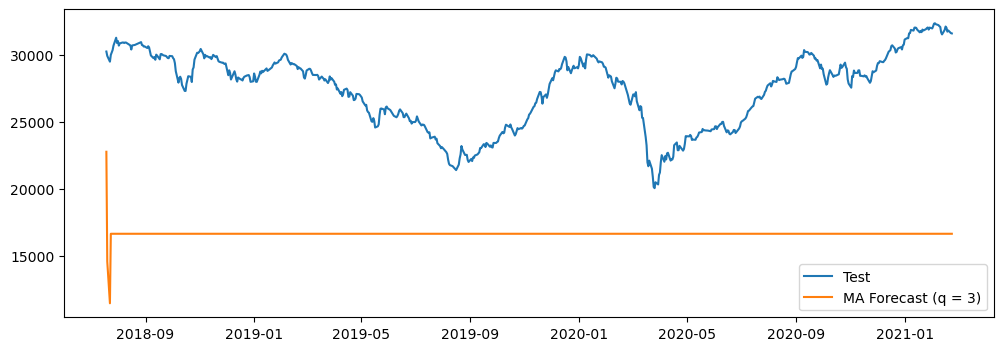

In [47]:
q = 3 #order of the MA (Moving Average) component
ma_model = ARIMA(train['Close'], order = (0,0, q)).fit()
ma_forecast = ma_model.predict(start = test.index[0], end = test.index[-1])

evaluation_series(test['Close'], ma_forecast, f'MA(q = {q}), ARIMA(0,0, {q})')

plt.figure(figsize = (12, 4))
plt.plot(test['Close'], label = 'Test')
plt.plot(ma_forecast, label = f'MA Forecast (q = {q})')
plt.legend()
plt.show()

MA(q = 2), ARIMA(0,0, 2) → RMSE: 3652.0575, MAE: 2762.4974


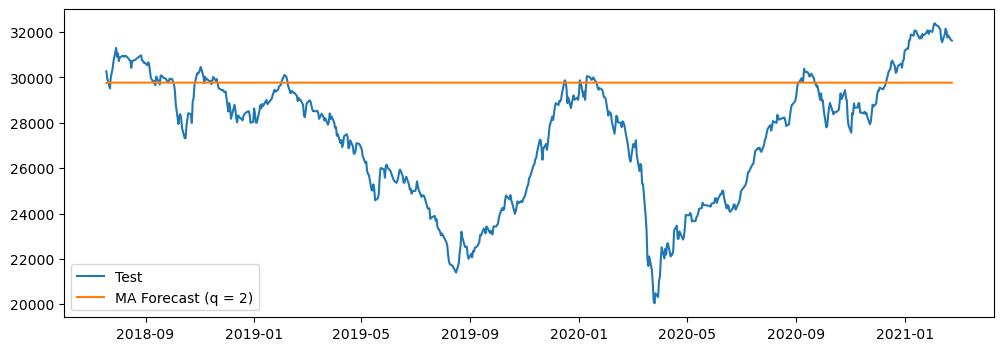

In [23]:
p =5 #pervious value kitni ko  dek ke result dena
d = 1 
q = 2
ma_model = ARIMA(train['Close'], order = (p,d, q)).fit()
ma_forecast = ma_model.predict(start = test.index[0], end = test.index[-1])

evaluation_series(test['Close'], ma_forecast, f'MA(q = {q}), ARIMA(0,0, {q})')

plt.figure(figsize = (12, 4))
plt.plot(test['Close'], label = 'Test')
plt.plot(ma_forecast, label = f'MA Forecast (q = {q})')
plt.legend()
plt.show()

MA(q = 1), SARIMAX(1, 1, 1) X (1, 1, 1) → RMSE: 2948.5697, MAE: 2217.2150


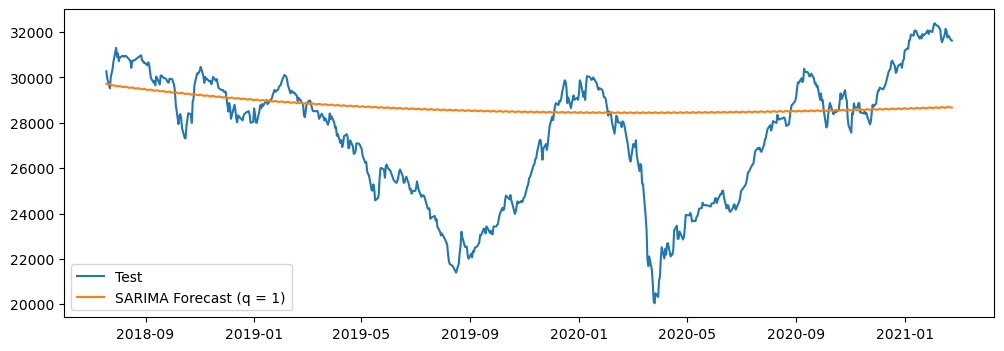

In [25]:
p, d, q = 1, 1,1
P, D, Q, s = 1,1,1,5

sarima_model = SARIMAX(train['Close'], order = (p, d, q), seasonal_order=(P, D, Q, s)).fit(disp = False)
sarima_forecast = sarima_model.predict(start = test.index[0], end = test.index[-1], type = 'levels')

evaluation_series(test['Close'], sarima_forecast, f'MA(q = {q}), SARIMAX({p}, {d}, {q}) X ({P}, {D}, {Q})')

plt.figure(figsize = (12, 4))
plt.plot(test['Close'], label = 'Test')
plt.plot(sarima_forecast, label = f'SARIMA Forecast (q = {q})')
plt.legend()
plt.show()

In [27]:
train_exog = np.log1p(train['Volume'])
test_exog = np.log1p(test['Volume'])

In [29]:
train_exog.interpolate(inplace= True)
test_exog.interpolate(inplace= True)

MA(q = 3), SARIMAX(1, 1, 3) X (1, 1, 1) → RMSE: 3617.5090, MAE: 2733.0530


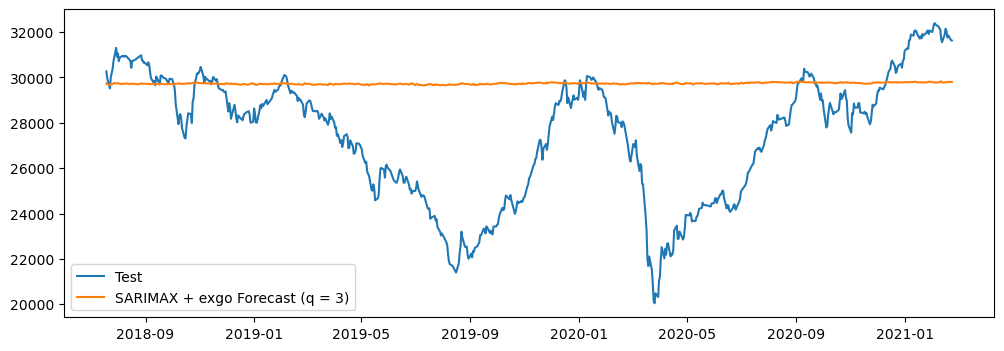

In [51]:
sarima1_model = SARIMAX(train['Close'],exog= train_exog ,order = (1, 1, 1), seasonal_order=(1, 0, 1, 5)).fit(disp = False)
sarima_forecast = sarima_model.predict(start = test.index[0], end = test.index[-1],exog = test_exog, type = 'levels')

evaluation_series(test['Close'], sarima_forecast, f'MA(q = {q}), SARIMAX({p}, {d}, {q}) X ({P}, {D}, {Q})')

plt.figure(figsize = (12, 4))
#plt.plot(train['Close'].iloc[-800:], label = 'Train (last 200)')
plt.plot(test['Close'], label = 'Test')
plt.plot(sarima_forecast, label = f'SARIMAX + exgo Forecast (q = {q})')
plt.legend()
plt.show()

In [33]:
import pickle

# Save the model
with open('ar_model.pkl', 'wb') as f:
    pickle.dump(ar_model, f)

In [53]:
import pickle

# Save the model
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(sarima_model, f)